In [96]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib
import warnings

In [112]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Parâmetros adicionais
n = 17
d = 45
t = 14
# Lista de parâmetros n para iterar
e_list = [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]  # Exemplo de diferentes valores de n
alpha = 0.20  # Mantemos um único valor de alpha

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)




price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Loop para calcular e salvar a variável para cada valor de 'e'
for e in e_list:
    # Calcula o Price Rate of Change para o valor atual de 'e'
    price_data[f'Price_Rate_Of_Change_{e}'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
        lambda x: x.pct_change(periods=e)
    )

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent


# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
warnings.filterwarnings("ignore")
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_16,Price_Rate_Of_Change_17,Price_Rate_Of_Change_18,Price_Rate_Of_Change_19,Price_Rate_Of_Change_20,Price_Rate_Of_Change_21,Price_Rate_Of_Change_22,Price_Rate_Of_Change_23,Price_Rate_Of_Change_24,Price_Rate_Of_Change_25,Price_Rate_Of_Change_26,Price_Rate_Of_Change_27,Price_Rate_Of_Change_28,Price_Rate_Of_Change_29,Price_Rate_Of_Change_30,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
11734,2024-11-11,59.750000,59.869999,58.650002,58.650002,58.131153,24483700,VALE3.SA,-1.980000,61.254148,-1.0,-0.002871,-0.006431,-0.010006,-0.008136,-0.010486,-0.010379,-0.009445,-0.011795,-0.015864,-0.020278,-0.018284,-0.017949,-0.015715,-0.007992,0.000402,1.980000,0.000000,34.686566,58.650002,-1.0,58.650002,63.990002,48.766795,-51.233205,0.318598,0.382283,2569015870,54.020000
11735,2024-11-12,58.580002,58.590000,57.200001,57.320000,56.812916,26967600,VALE3.SA,-1.330002,60.467319,-1.0,-0.012140,-0.015679,-0.019194,-0.022723,-0.020877,-0.023196,-0.023091,-0.022169,-0.024489,-0.028506,-0.032863,-0.030894,-0.030564,-0.028358,-0.020735,1.330002,0.000000,30.235106,57.320000,-1.0,57.200001,63.990002,48.119551,-51.880449,0.198989,0.345624,2542048270,52.660000
11736,2024-11-13,57.320000,57.720001,57.110001,57.160000,56.654331,20354900,VALE3.SA,-0.160000,59.805855,-1.0,-0.020384,-0.022946,-0.026447,-0.029923,-0.033414,-0.031588,-0.033882,-0.033777,-0.032866,-0.035160,-0.039133,-0.043442,-0.041495,-0.041168,-0.038987,0.160000,0.000000,29.718934,57.160000,-1.0,57.110001,63.990002,39.183923,-60.816077,0.050244,0.286548,2521693370,52.320000
11737,2024-11-14,57.160000,57.340000,56.840000,56.840000,56.337162,17967600,VALE3.SA,-0.320000,59.212684,-1.0,-0.024668,-0.030100,-0.032637,-0.036103,-0.039544,-0.043001,-0.041193,-0.043464,-0.043361,-0.042458,-0.044729,-0.048663,-0.052930,-0.051002,-0.050678,0.320000,0.000000,28.619602,56.840000,-1.0,56.840000,63.990002,33.184382,-66.815618,-0.114185,0.206402,2503725770,53.029999
11738,2024-11-18,57.090000,57.779999,56.970001,57.549999,57.040882,14300000,VALE3.SA,0.709999,58.880147,-1.0,-0.026906,-0.030145,-0.035547,-0.038070,-0.041516,-0.044938,-0.048375,-0.046577,-0.048836,-0.048733,-0.047835,-0.050094,-0.054006,-0.058249,-0.056331,0.000000,0.709999,34.653256,57.549999,-1.0,56.840000,63.990002,28.533517,-71.466483,-0.268237,0.111474,2489425770,52.910000


In [113]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_16,Price_Rate_Of_Change_17,Price_Rate_Of_Change_18,Price_Rate_Of_Change_19,Price_Rate_Of_Change_20,Price_Rate_Of_Change_21,Price_Rate_Of_Change_22,Price_Rate_Of_Change_23,Price_Rate_Of_Change_24,Price_Rate_Of_Change_25,Price_Rate_Of_Change_26,Price_Rate_Of_Change_27,Price_Rate_Of_Change_28,Price_Rate_Of_Change_29,Price_Rate_Of_Change_30,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
5701,2024-11-11,12.31,12.55,12.26,12.51,12.270372,20684800,ABEV3.SA,0.180000,12.586564,-1.0,-0.037523,-0.040042,-0.043535,-0.044433,-0.046096,-0.048166,-0.049127,-0.048352,-0.045213,-0.035382,-0.025076,-0.021861,-0.020870,-0.021152,-0.024538,0.000000,0.18,39.942916,12.51,-1.0,12.26,13.09,39.345088,-60.654912,-0.081478,-0.033515,-2321489347,11.25
5702,2024-11-12,12.43,12.64,12.30,12.58,12.339031,26899600,ABEV3.SA,0.070000,12.585252,-1.0,-0.034415,-0.037623,-0.040142,-0.043635,-0.044533,-0.046195,-0.048265,-0.049227,-0.048451,-0.045313,-0.035483,-0.025177,-0.021963,-0.020972,-0.021254,0.000000,0.07,44.092382,12.58,-1.0,12.26,13.09,39.186907,-60.813093,-0.089866,-0.044785,-2348388947,11.02
5703,2024-11-13,12.52,12.77,12.46,12.73,12.486157,30341700,ABEV3.SA,0.150000,12.614201,-1.0,-0.029904,-0.032194,-0.035409,-0.037934,-0.041435,-0.042335,-0.044001,-0.046076,-0.047040,-0.046263,-0.043117,-0.033264,-0.022935,-0.019714,-0.018720,0.000000,0.15,52.074863,12.73,-1.0,12.26,13.09,42.674811,-57.325189,-0.093104,-0.054449,-2318047247,11.05
5704,2024-11-14,12.69,12.90,12.61,12.64,12.397882,38027500,ABEV3.SA,-0.089999,12.619361,-1.0,-0.026917,-0.029507,-0.031798,-0.035015,-0.037540,-0.041043,-0.041943,-0.043610,-0.045686,-0.046650,-0.045872,-0.042725,-0.032869,-0.022535,-0.019313,0.089999,0.00,47.497276,12.64,-1.0,12.26,13.09,43.296479,-56.703521,-0.094169,-0.062393,-2280019747,10.87
5705,2024-11-18,12.48,12.67,12.38,12.42,12.182096,37251000,ABEV3.SA,-0.220000,12.579489,-1.0,-0.027766,-0.029992,-0.032574,-0.034857,-0.038064,-0.040581,-0.044073,-0.044970,-0.046632,-0.048701,-0.049662,-0.048887,-0.045750,-0.035924,-0.025624,0.220000,0.00,38.250631,12.42,-1.0,12.26,13.09,38.492602,-61.507398,-0.097111,-0.069337,-2317270747,10.91


e: 16
Fold 1:
 - Correct Prediction (y_test): 52.96%
 - Correct Prediction (Verify): 52.64%
Fold 2:
 - Correct Prediction (y_test): 42.92%
 - Correct Prediction (Verify): 42.81%
Fold 3:
 - Correct Prediction (y_test): 60.89%
 - Correct Prediction (Verify): 59.30%
Fold 4:
 - Correct Prediction (y_test): 61.21%
 - Correct Prediction (Verify): 59.41%
Fold 5:
 - Correct Prediction (y_test): 49.47%
 - Correct Prediction (Verify): 48.73%
Média de acurácia (y_test) para e 16: 53.49%
Média de acurácia (Verify) para e 16: 52.58%
---
e: 17
Fold 1:
 - Correct Prediction (y_test): 47.04%
 - Correct Prediction (Verify): 46.93%
Fold 2:
 - Correct Prediction (y_test): 43.66%
 - Correct Prediction (Verify): 43.76%
Fold 3:
 - Correct Prediction (y_test): 60.57%
 - Correct Prediction (Verify): 59.20%
Fold 4:
 - Correct Prediction (y_test): 60.68%
 - Correct Prediction (Verify): 59.09%
Fold 5:
 - Correct Prediction (y_test): 48.73%
 - Correct Prediction (Verify): 47.78%
Média de acurácia (y_test) para e 

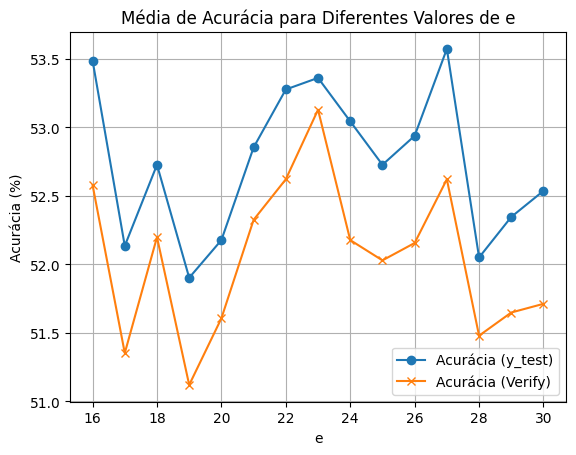

In [114]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por e
mean_accuracy_by_e = []

# Loop para cada e em n_list e realização de validação cruzada em série temporal
for e in e_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    f'Price_Rate_Of_Change_{e}',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse e
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'e: {e}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por e
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_e.append((e, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para e {e}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para e {e}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for e, acc_ytest, acc_verify in mean_accuracy_by_e:
    print(f'e: {e} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por e
import matplotlib.pyplot as plt

e_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_e)

plt.plot(e_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(e_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de e")
plt.xlabel('e')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)